I0000 00:00:1727068345.227233 2040427 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1727068345.310961 2043234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1727068345.327656 2043238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1727068345.346484 2043235 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is

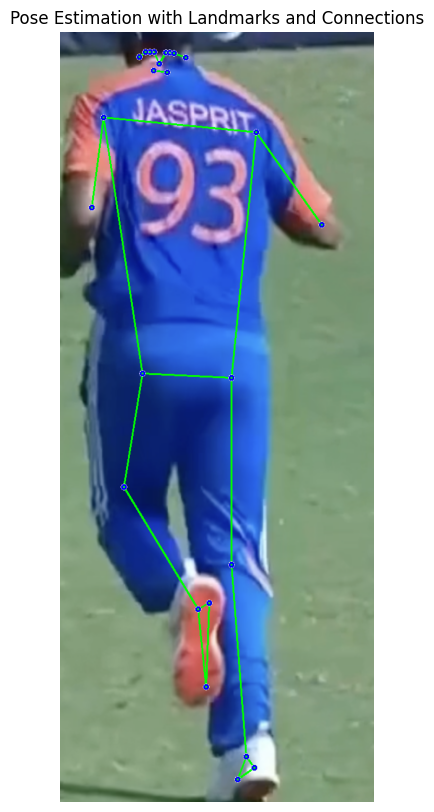

In [4]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Initialize drawing utilities for pose visualization
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def detect_and_visualize_pose(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform pose detection
    results = pose.process(image_rgb)

    if not results.pose_landmarks:
        print("No pose landmarks detected.")
        return

    # Create a copy of the image to draw landmarks and connections
    annotated_image = image.copy()

    # Draw landmarks and connections on the image
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=3),  # Customize landmark style
        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)   # Customize connection style
    )

    # Convert the image back to RGB for matplotlib
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    # Display the annotated image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image_rgb)
    plt.title('Pose Estimation with Landmarks and Connections')
    plt.axis('off')
    plt.show()



# Example usage
image_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/1.png' 
detect_and_visualize_pose(image_path)


In [96]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [204]:
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load YOLO model
def load_yolo():
    path_to_cfg = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.cfg"
    path_to_weights = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.weights"
    net = cv2.dnn.readNet(path_to_weights, path_to_cfg)
    layers_names = net.getLayerNames()
    
    # Handling different versions of OpenCV which may return different formats
    try:
        output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return net, output_layers

# Perform YOLO detection on an image
def yolo_detect(net, image, output_layers, confidence_threshold=0.3):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_id == 0:  # Person class
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                if x >= 0 and y >= 0 and (x + w) <= width and (y + h) <= height:
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))

    # Select the largest box if boxes were detected
    if boxes:
        largest_box = max(boxes, key=lambda b: b[2] * b[3])  # b[2]*b[3] is the area of the box (w*h)
        largest_confidence = confidences[boxes.index(largest_box)]
        return [largest_box], [largest_confidence]
    return [], []  # Return empty lists if no boxes detected

In [205]:
# Initialize MediaPipe Pose Estimation
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Extract pose landmarks from the cropped image
def extract_pose_landmarks(cropped_img):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    
    # Perform pose detection
    results = pose.process(image_rgb)

    # If landmarks are detected
    if results.pose_landmarks:
        landmarks = []
        for landmark in results.pose_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y, landmark.z])
        return np.array(landmarks).flatten()
    return None

I0000 00:00:1727496707.113775 2040427 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


W0000 00:00:1727496707.223838 3322105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1727496707.265556 3322109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [206]:
# Calculate step length between left and right ankles
def calculate_step_length(pose_sequence):
    left_ankle_x, left_ankle_y = pose_sequence[27*3], pose_sequence[27*3 + 1]  # left ankle
    right_ankle_x, right_ankle_y = pose_sequence[28*3], pose_sequence[28*3 + 1]  # right ankle
    step_length = np.linalg.norm(np.array([right_ankle_x, right_ankle_y]) - np.array([left_ankle_x, left_ankle_y]))
    return step_length

# Calculate joint velocities between two consecutive frames
def calculate_velocity(pose_sequence_t, pose_sequence_t1, joint_index):
    joint_t = np.array([pose_sequence_t[joint_index*3], pose_sequence_t[joint_index*3 + 1]])
    joint_t1 = np.array([pose_sequence_t1[joint_index*3], pose_sequence_t1[joint_index*3 + 1]])
    velocity = np.linalg.norm(joint_t1 - joint_t)
    return velocity

# Calculate joint angles (hip-knee-ankle)
def calculate_joint_angle(pose_sequence, hip_idx, knee_idx, ankle_idx):
    hip = np.array([pose_sequence[hip_idx*3], pose_sequence[hip_idx*3 + 1]])
    knee = np.array([pose_sequence[knee_idx*3], pose_sequence[knee_idx*3 + 1]])
    ankle = np.array([pose_sequence[ankle_idx*3], pose_sequence[ankle_idx*3 + 1]])
    
    # Calculate vectors
    vec_hip_knee = knee - hip
    vec_knee_ankle = ankle - knee
    
    # Calculate the cosine of the angle between the vectors
    cos_angle = np.dot(vec_hip_knee, vec_knee_ankle) / (np.linalg.norm(vec_hip_knee) * np.linalg.norm(vec_knee_ankle))
    angle = np.arccos(cos_angle)
    return np.degrees(angle)

In [207]:
# Function to calculate temporal features (step length, velocity, joint angles)
def calculate_features(pose_landmarks, previous_landmarks=None):
    frame_features = [0] * 5  # Five features (step length, velocity x2, joint angles x2)

    # Step Length
    step_length = calculate_step_length(pose_landmarks)
    frame_features[0] = step_length

    # Joint Velocities (use previous landmarks if available)
    if previous_landmarks is not None:
        left_ankle_velocity = calculate_velocity(previous_landmarks, pose_landmarks, 27)
        right_ankle_velocity = calculate_velocity(previous_landmarks, pose_landmarks, 28)
        frame_features[1] = left_ankle_velocity
        frame_features[2] = right_ankle_velocity

    # Joint Angles (hip-knee-ankle)
    left_leg_angle = calculate_joint_angle(pose_landmarks, 23, 25, 27)
    right_leg_angle = calculate_joint_angle(pose_landmarks, 24, 26, 28)
    frame_features[3] = left_leg_angle
    frame_features[4] = right_leg_angle

    return frame_features

In [208]:
def load_and_preprocess_data(root_folder, net, output_layers):
    features = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

    for player_name in os.listdir(root_folder):
        player_folder = os.path.join(root_folder, player_name)
        if os.path.isdir(player_folder):
            previous_landmarks = None
            for img_file in os.listdir(player_folder):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(player_folder, img_file)
                    img = cv2.imread(img_path)
                    if img is None or img.size == 0:
                        print(f"Failed to load image {img_path}.")
                        continue

                    # Detect player using YOLO
                    boxes, _ = yolo_detect(net, img, output_layers)

                    for box in boxes:
                        x, y, w, h = box
                        if w > 0 and h > 0:
                            cropped_img = img[y:y+h, x:x+w]

                            # Extract pose landmarks using MediaPipe Pose
                            pose_landmarks = extract_pose_landmarks(cropped_img)
                            if pose_landmarks is not None:
                                # Extract temporal features (step length, velocity, joint angles)
                                frame_features = calculate_features(pose_landmarks, previous_landmarks)

                                # Store current landmarks as previous for velocity calculation
                                previous_landmarks = pose_landmarks

                                # Append frame features
                                features.append(frame_features)
                                labels.append(player_name)  # Append player name as label

    if not features:
        print("No valid images or features found in dataset.")
        return np.array([]), np.array([]), None  # Return empty arrays if no data

    features = np.array(features, dtype=np.float32)  # Ensure consistent data type

    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    return features, encoded_labels, encoder

In [209]:
# Group features by player
def group_features_by_player(features, labels):
    grouped_data = {}

    for feature_set, label in zip(features, labels):
        if label not in grouped_data:
            grouped_data[label] = []
        grouped_data[label].append(feature_set)

    return grouped_data

# Create sequences from grouped features
def create_sequences(grouped_data, sequence_length=10):
    sequences = []
    labels = []

    for label, features in grouped_data.items():
        # Generate sequences of features for each player
        for i in range(len(features) - sequence_length + 1):
            sequence = features[i:i + sequence_length]
            sequences.append(sequence)
            labels.append(label)

    return np.array(sequences), np.array(labels)

# Prepare the data for LSTM
def prepare_lstm_data(features, labels, sequence_length=10):
    # Group the features by player
    grouped_data = group_features_by_player(features, labels)

    # Create sequences of features
    sequences, labels = create_sequences(grouped_data, sequence_length)

    # Reshape the sequences to the format (samples, timesteps, features)
    sequences = sequences.reshape((sequences.shape[0], sequence_length, -1))  # -1 to handle multiple features

    return sequences, labels

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Build the LSTM model
def build_lstm_model(sequence_length, num_features, num_classes):

    model = Sequential()
    model.add(GRU(128, input_shape=(sequence_length, num_features), return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.07)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.07)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [249]:
# Function to apply moving average smoothing
def smooth_curve(points, factor=0.7):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Function to plot accuracy and loss curves with smoothing
def plot_training_history(history, smoothing_factor=0.7):
    # Apply smoothing to accuracy and loss values
    acc = smooth_curve(history.history['accuracy'], smoothing_factor)
    val_acc = smooth_curve(history.history['val_accuracy'], smoothing_factor)
    loss = smooth_curve(history.history['loss'], smoothing_factor)
    val_loss = smooth_curve(history.history['val_loss'], smoothing_factor)

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Function to display the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to display the classification report
def print_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Extracted features shape: (729, 5)
Number of labels: 729
Training data shape: (516, 15, 5)
Testing data shape: (129, 15, 5)
Epoch 1/50


/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1525 - loss: 7.5839 - val_accuracy: 0.2093 - val_loss: 6.6484
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1864 - loss: 6.5541 - val_accuracy: 0.1783 - val_loss: 5.9201
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1792 - loss: 5.7878 - val_accuracy: 0.1860 - val_loss: 5.2837
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1872 - loss: 5.1371 - val_accuracy: 0.2558 - val_loss: 4.7021
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1931 - loss: 4.6026 - val_accuracy: 0.2868 - val_loss: 4.1908
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1898 - loss: 4.1373 - val_accuracy: 0.3721 - val_loss: 3.7841
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2248 - loss: 3.7294 - val_accuracy: 0.2791 - val_loss: 3.4358
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2136 - loss: 3.3704 - val_accuracy: 0.2868 - val_loss: 3.1448
Ep

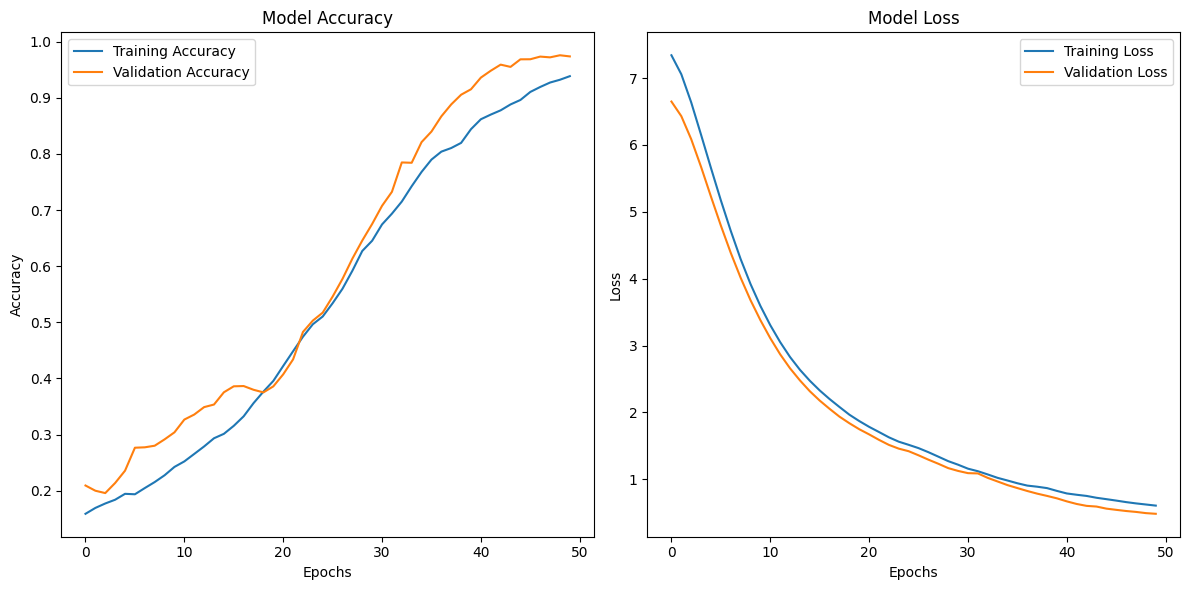

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


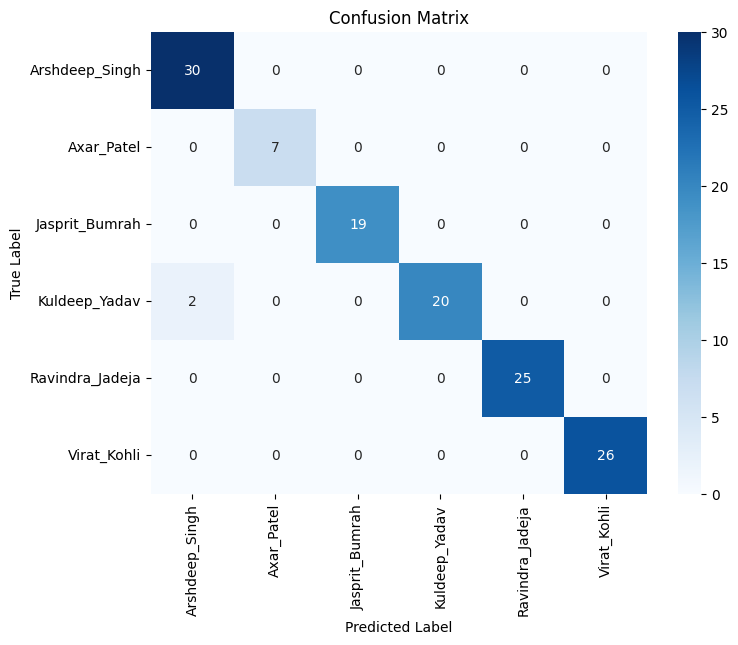

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.94      1.00      0.97        30
     Axar_Patel       1.00      1.00      1.00         7
 Jasprit_Bumrah       1.00      1.00      1.00        19
  Kuldeep_Yadav       1.00      0.91      0.95        22
Ravindra_Jadeja       1.00      1.00      1.00        25
    Virat_Kohli       1.00      1.00      1.00        26

       accuracy                           0.98       129
      macro avg       0.99      0.98      0.99       129
   weighted avg       0.99      0.98      0.98       129



In [250]:
# Example Usage:
output_frame_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
net, output_layers = load_yolo()  # Load YOLO model
features, labels, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers)  # Load and preprocess data

sequence_length = 15  # Define the sequence length (number of frames per sequence)

# Prepare the LSTM data (features grouped into sequences)
lstm_sequences, lstm_labels = prepare_lstm_data(features, labels, sequence_length)

print(f"Extracted features shape: {features.shape}")
print(f"Number of labels: {len(labels)}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lstm_sequences, lstm_labels, test_size=0.2, random_state=42)

# Each sequence now has multiple features
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Initialize the model
num_features = X_train.shape[2]  # Automatically detect the number of features (step length, velocity, angles, etc.)
num_classes = len(encoder.classes_)  # Number of players
lstm_model = build_lstm_model(sequence_length, num_features, num_classes)

# Add early stopping to the training process
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), 
                         callbacks=[early_stopping])
                         
# Evaluate the model
train_loss, train_acc = lstm_model.evaluate(X_train, y_train)
print(f"Train accuracy: {train_acc}")
test_loss, test_acc = lstm_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Plot training history (accuracy and loss)
plot_training_history(history)

# Make predictions
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_classes, encoder.classes_)

# Print classification report
print_classification_report(y_test, y_pred_classes, encoder.classes_)